### In this notebook, we will demonstrate techniques to detect moving objects in a video from a CCTV camera. The camera will be in a fixed position and does not move.

# 1.Import libraries

In [1]:
import numpy as np
import cv2

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
np.random.seed(42)

#### we have to define a routine to fix a color issue to ensure colors are seen correctly in matplotlib

In [3]:
#Routine to fix 
def fixColor(image):
    return(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# 2.Input Operations

In [4]:
from IPython.display import Video

##### Extract background in a video.
We identify a background we will have to use filtering techniques. An easy way to do this is to take a few random frames from the video and finding the median of it. We do this by finding the median of every pixel. This works because most of the time there is no vehicle passing over the road. The median will end filtering all moving objects in the video.

We capture the video in a video stream and get 30 random frames. These frames are saved in the array frames.

In [5]:
video_stream = cv2.VideoCapture('video.mp4')

# Randomly select 30 frames
frameIds = video_stream.get(cv2.CAP_PROP_FRAME_COUNT) * np.random.uniform(size=30)

# Store selected frames in an array
frames = []
for fid in frameIds:
    video_stream.set(cv2.CAP_PROP_POS_FRAMES, fid)
    ret, frame = video_stream.read()
    frames.append(frame)
    
video_stream.release()

We will now calculate the median and average frames for saved frames. We will use the median as it remove outliers better.

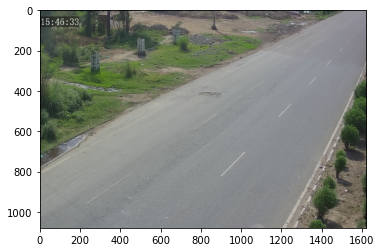

In [6]:
# Calculate the median along the time axis
medianFrame = np.median(frames, axis=0).astype(dtype=np.uint8)
medianFrame = medianFrame[:,300:]
plt.imshow(fixColor(medianFrame))

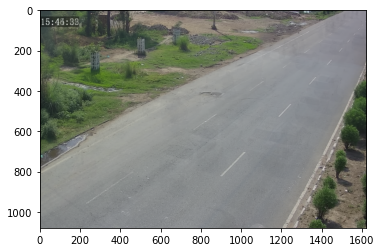

In [7]:
# Calculate the average along the time axis
avgFrame = np.average(frames, axis=0).astype(dtype=np.uint8)
avgFrame = avgFrame[:,300:]
plt.imshow(fixColor(avgFrame))

##### Processing a frame

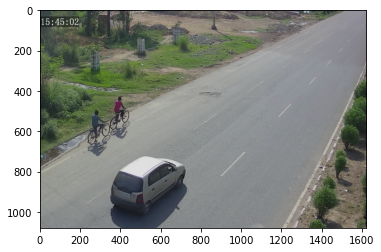

In [8]:
sample_frame=frames[0]
sample_frame = sample_frame[:,300:]
plt.imshow(fixColor(sample_frame))

This is the first frame from our frames array. We can see a few cycles and a car in the picture here.

For identifying moving objects it is better to work with grayscale images. We will convert both the median image and sample image to grayscale.

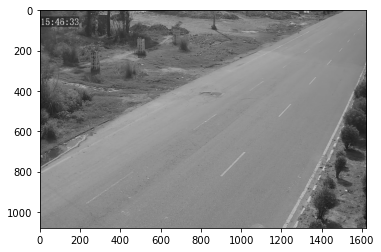

In [9]:
grayMedianFrame = cv2.cvtColor(medianFrame, cv2.COLOR_BGR2GRAY)
plt.imshow(fixColor(grayMedianFrame))

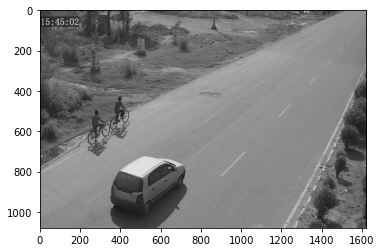

In [10]:
graySample=cv2.cvtColor(sample_frame, cv2.COLOR_BGR2GRAY)
plt.imshow(fixColor(graySample))

# 3.Removing background

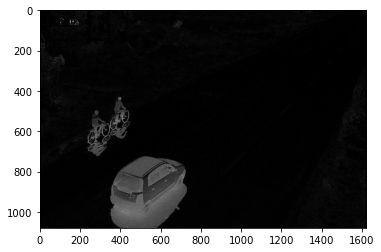

In [11]:
dframe = cv2.absdiff(graySample, grayMedianFrame)
plt.imshow(fixColor(dframe))

# 4.Blurring

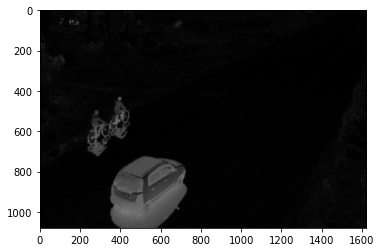

In [12]:
blurred = cv2.GaussianBlur(dframe, (11,11), 0)
plt.imshow(fixColor(blurred))

Here Gaussian blurring is used to reduce noise and enable easier identification of edges.

# 5.Thresholding

OTSU thresholding can automatically figure out the correct thresold levels.Here OTSU thresholding can be used.

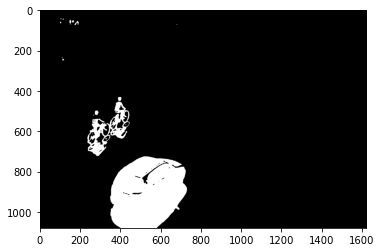

In [13]:
ret, tframe= cv2.threshold(blurred,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.imshow(fixColor(tframe))

# 6.Contour and Bounding Boxes

contours are drawn using the thresholded pictures

In [14]:
(cnts, _) = cv2.findContours(tframe.copy(), cv2.RETR_EXTERNAL, 
                             cv2 .CHAIN_APPROX_SIMPLE)

Here bounding boxes for the contours identified and show them on our sample images.

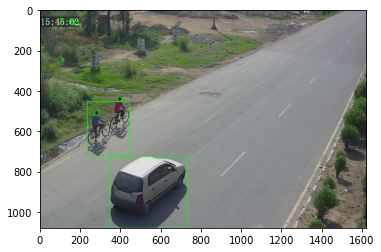

In [15]:
for cnt in cnts:
    x,y,w,h = cv2.boundingRect(cnt)
    cv2.rectangle(sample_frame,(x,y),(x+w,y+h),(0,255,0),2)

plt.imshow(fixColor(sample_frame))

# 7 Putting in together for processing video

Here the output video will be created. We use in-built CV2 create an MP4 video, with 30 fps and frame size 640*480

In [16]:
writer = cv2.VideoWriter("output.mp4", 
                         cv2.VideoWriter_fourcc(*"MP4V"), 30,(640,480))

In [22]:
#Create a new video stream and get total frame count
video_stream = cv2.VideoCapture('video.mp4')
total_frames=video_stream.get(cv2.CAP_PROP_FRAME_COUNT)
total_frames

TypeError: 'cv2.VideoCapture' object is not subscriptable

In [23]:
frameCnt=0
while(frameCnt < total_frames-1):

    frameCnt+=1
    ret, frame = video_stream.read()
    frame = frame[:,300:]

    # Convert current frame to grayscale
    gframe = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # Calculate absolute difference of current frame and
    # the median frame
    dframe = cv2.absdiff(gframe, grayMedianFrame)
    # Gaussian
    blurred = cv2.GaussianBlur(dframe, (11, 11), 0)
    #Thresholding to binarise
    ret, tframe= cv2.threshold(blurred,0,255,
                               cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    #Identifying contours from the threshold
    (cnts, _) = cv2.findContours(tframe.copy(), 
                                 cv2.RETR_EXTERNAL, cv2 .CHAIN_APPROX_SIMPLE)
    #For each contour draw the bounding bos
    for cnt in cnts:
        x,y,w,h = cv2.boundingRect(cnt)
        cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,0),2)

    writer.write(cv2.resize(frame, (640,480)))
 
#Release video object
video_stream.release()
writer.release()
